Here, we're going to explore predictive text methods based on a corpus of Trump tweets. For this, a collections of Trump's 26,560 (as of July 6, 2019) tweets has been downloaded in JSON format. These do not include retweets or extraneous information like favorites or datetimes, so the data is already pretty easy to work with. Let's start by getting our data into a dataframe using pandas.

In [30]:
import pandas as pd

In [31]:
# File is encoded with utf-8 and is a string, 
# but pandas can handle this with the .read_json method
with open('trumptweets', encoding='utf-8') as f:
    df = pd.read_json(f)

In [32]:
# Check out the df
df.head()

,text
0,....As well as we are doing from the day after...
1,"Strong jobs report, low inflation, and other c..."
2,My deepest sympathies go out to the family and...
3,Happy Birthday to our great United States @Sec...
4,"“Record 157,005,000 Employed; 19th Record of T..."


In [33]:
df.shape

(26560, 1)

In [34]:
df.iloc[0].text

'....As well as we are doing from the day after the great Election, when the Market shot right up, it could have been even better - massive additional wealth would have been created, &amp; used very well. Our most difficult problem is not our competitors, it is the Federal Reserve!'

Looks good so far. We have all the tweets loaded into our dataframe, and now we're ready to start cleaning up the data. Let's start by tokenizing the text, removing punctuation, and URLs.

In [39]:
import spacy
nlp = spacy.load('en',disable=['parser', 'tagger','ner'])

nlp.max_length = 2125923

In [36]:
# Load our ['tweets'] column into a long string format. 
tweets = ' '.join(df['text'].values.tolist())

In [37]:
# Remove URLs using regular expressions
import re
tweets = re.sub(r'^https?:\/\/.*[\r\n]*', '', tweets, flags=re.MULTILINE)

In [40]:
# Let's make a list of all the extraneous non-alpha tokens. We'll 
# use this list to remove those tokens before the learning process
removals = []
for token in nlp.tokenizer(tweets):
    if not token.text.isalpha():
        if token.text not in [',', '.', '\'', ' ','?','!', '\'s', 'n\'t']: # Note, this is a very crude way of doing this
            removals.append(token.text)
removalset = set(removals)

# Remove extraneous punctuation. 
def separate_punc(doc_text):
        return [token.text.lower() for token in nlp(doc_text) if token.text not in removalset]

tokens = separate_punc(tweets)

Now that the text has been tokenized (every token has been added to a list), we can vectorize it for input to a neural network later. Once that's complete, we can vectorize each of the tweets and begin computing conditional probabilities.

In [41]:
# Let's look at our tokens:
print(f"The first 20 tokens: {tokens[0:20]}\n")
print(f"Length of the aggregated tweets: {len(tokens)}\n")
print(f"Total number of unique tokens:  {len(set(tokens))}\n")

The first 20 tokens: ['as', 'well', 'as', 'we', 'are', 'doing', 'from', 'the', 'day', 'after', 'the', 'great', 'election', ',', 'when', 'the', 'market', 'shot', 'right', 'up']

Length of the aggregated tweets: 360035

Total number of unique tokens:  13764



In [42]:
# Organize into sequences of tokens. This gives us a line of 25 + 1 words;
# 25 for context, and then a last word for the  model to predict. In this 
# way, we have 'labeled' data to train on and validate loss during model training.

train_len = 14+1 # 10 training words , then one target word

# Empty list of sequences
text_sequences = []

for i in range(train_len, len(tokens)):
    
    # Grab train_len (# of tokens)
    seq = tokens[i-train_len:i]
    
    # Add to list of sequences
    text_sequences.append(seq)

In [44]:
# Now we need to convert these tokens to numeric values
# based on a tokenizer, and finally, vectorize them.
from keras.preprocessing.text import Tokenizer

# integer encode sequences of words
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text_sequences)
sequences = tokenizer.texts_to_sequences(text_sequences)

In [45]:
import numpy as np

sequences = np.array(sequences)

In [47]:
# Check to make sure Keras with tensorflow backend is 
# using the GPU. You can comment this out if you're 
# not using CUDA or GPU for TF. 
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

So let's check out what we've done. We've changed every token into its numeric value based on its position in the token list. Numeric IDs are unique to the token they represent. Now comes the memory-intensive stuff. We'll import Keras layers, build an LSTM neural network, and one-hot encode the entirety of our text in a giant sparse matrix that Keras can handle.

In [48]:
# Numeric representation of the text!
sequences

array([[  46,  166,   46, ...,  162,    3,   85],
       [ 166,   46,   26, ...,    3,   85,    2],
       [  46,   26,   21, ...,   85,    2,  385],
       ...,
       [ 230,    4,   31, ...,  560,   59,    2],
       [   4,   31, 5368, ...,   59,    2,   31],
       [  31, 5368, 2525, ...,    2,   31,  353]])

In [49]:
import keras
from keras.models import Sequential
from keras.layers import Dense,LSTM,Embedding

def create_model(vocabulary_size, seq_len):
    model = Sequential()
    model.add(Embedding(vocabulary_size, 25, input_length=seq_len))
    model.add(LSTM(150, return_sequences=True))
    model.add(LSTM(150))
    model.add(Dense(150, activation='relu'))

    model.add(Dense(vocabulary_size, activation='softmax'))
    
    # Normally, we'd train with categorical_crossentropy loss. However, 
    # the training data is huge. Creating a one-hot encoded matrix for 
    # all vocabulary would take nearly 40 GB of RAM. Instead, we can use
    # sparse_categorical_crossentropy to feed the model integer-value
    # labels, without the need to one-hot encode all training labels.
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
   
    model.summary()
    
    return model

In [50]:
vocabulary_size = len(set(tokens))
X = sequences[:,:-1]
y = sequences[:,-1]

In [53]:
seq_len = 14
model = create_model(vocabulary_size+1, seq_len)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 14, 25)            344125    
_________________________________________________________________
lstm_5 (LSTM)                (None, 14, 150)           105600    
_________________________________________________________________
lstm_6 (LSTM)                (None, 150)               180600    
_________________________________________________________________
dense_5 (Dense)              (None, 150)               22650     
_________________________________________________________________
dense_6 (Dense)              (None, 13765)             2078515   
Total params: 2,731,490
Trainable params: 2,731,490
Non-trainable params: 0
_________________________________________________________________


In [54]:
# Fit the model 

model.fit(X, y, batch_size=1024, epochs=1100,verbose=2)

Epoch 1/1800
 - 72s - loss: 6.8211 - acc: 0.0458
Epoch 2/1800
 - 67s - loss: 6.4256 - acc: 0.0686
Epoch 3/1800
 - 69s - loss: 6.2313 - acc: 0.0799
Epoch 4/1800
 - 72s - loss: 6.0778 - acc: 0.0911
Epoch 5/1800
 - 71s - loss: 5.9311 - acc: 0.1044
Epoch 6/1800
 - 72s - loss: 5.7963 - acc: 0.1129
Epoch 7/1800
 - 72s - loss: 5.6830 - acc: 0.1194
Epoch 8/1800
 - 74s - loss: 5.5845 - acc: 0.1253
Epoch 9/1800
 - 73s - loss: 5.4954 - acc: 0.1301
Epoch 10/1800
 - 75s - loss: 5.4190 - acc: 0.1353
Epoch 11/1800
 - 81s - loss: 5.3502 - acc: 0.1394
Epoch 12/1800
 - 75s - loss: 5.2844 - acc: 0.1437
Epoch 13/1800
 - 73s - loss: 5.2232 - acc: 0.1473
Epoch 14/1800
 - 73s - loss: 5.1655 - acc: 0.1515
Epoch 15/1800
 - 73s - loss: 5.1107 - acc: 0.1543
Epoch 16/1800
 - 73s - loss: 5.0582 - acc: 0.1579
Epoch 17/1800
 - 73s - loss: 5.0063 - acc: 0.1605
Epoch 18/1800
 - 72s - loss: 4.9572 - acc: 0.1635
Epoch 19/1800
 - 73s - loss: 4.9105 - acc: 0.1655
Epoch 20/1800
 - 72s - loss: 4.8627 - acc: 0.1684
Epoch 21/

Epoch 164/1800
 - 73s - loss: 2.8028 - acc: 0.4123
Epoch 165/1800
 - 74s - loss: 2.7962 - acc: 0.4129
Epoch 166/1800
 - 75s - loss: 2.7850 - acc: 0.4151
Epoch 167/1800
 - 73s - loss: 2.7800 - acc: 0.4151
Epoch 168/1800
 - 73s - loss: 2.7718 - acc: 0.4173
Epoch 169/1800
 - 73s - loss: 2.7675 - acc: 0.4173
Epoch 170/1800
 - 73s - loss: 2.7608 - acc: 0.4189
Epoch 171/1800
 - 73s - loss: 2.7527 - acc: 0.4198
Epoch 172/1800
 - 74s - loss: 2.7464 - acc: 0.4209
Epoch 173/1800
 - 74s - loss: 2.7373 - acc: 0.4227
Epoch 174/1800
 - 73s - loss: 2.7307 - acc: 0.4239
Epoch 175/1800
 - 74s - loss: 2.7240 - acc: 0.4247
Epoch 176/1800
 - 73s - loss: 2.7183 - acc: 0.4252
Epoch 177/1800
 - 73s - loss: 2.7107 - acc: 0.4271
Epoch 178/1800
 - 74s - loss: 2.7036 - acc: 0.4281
Epoch 179/1800
 - 74s - loss: 2.6974 - acc: 0.4291
Epoch 180/1800
 - 73s - loss: 2.6887 - acc: 0.4304
Epoch 181/1800
 - 74s - loss: 2.6826 - acc: 0.4313
Epoch 182/1800
 - 73s - loss: 2.6778 - acc: 0.4320
Epoch 183/1800
 - 74s - loss: 2

Epoch 325/1800
 - 74s - loss: 2.0512 - acc: 0.5409
Epoch 326/1800
 - 75s - loss: 2.0520 - acc: 0.5402
Epoch 327/1800
 - 75s - loss: 2.0503 - acc: 0.5401
Epoch 328/1800
 - 74s - loss: 2.0479 - acc: 0.5410
Epoch 329/1800
 - 74s - loss: 2.0466 - acc: 0.5410
Epoch 330/1800
 - 74s - loss: 2.0443 - acc: 0.5410
Epoch 331/1800
 - 74s - loss: 2.0388 - acc: 0.5425
Epoch 332/1800
 - 74s - loss: 2.0408 - acc: 0.5419
Epoch 333/1800
 - 74s - loss: 2.0359 - acc: 0.5431
Epoch 334/1800
 - 74s - loss: 2.0306 - acc: 0.5440
Epoch 335/1800
 - 74s - loss: 2.0296 - acc: 0.5439
Epoch 336/1800
 - 75s - loss: 2.0340 - acc: 0.5427
Epoch 337/1800
 - 73s - loss: 2.0346 - acc: 0.5418
Epoch 338/1800
 - 73s - loss: 2.0298 - acc: 0.5433
Epoch 339/1800
 - 74s - loss: 2.0200 - acc: 0.5458
Epoch 340/1800
 - 74s - loss: 2.0189 - acc: 0.5459
Epoch 341/1800
 - 75s - loss: 2.0165 - acc: 0.5463
Epoch 342/1800
 - 74s - loss: 2.0184 - acc: 0.5456
Epoch 343/1800
 - 73s - loss: 2.0076 - acc: 0.5478
Epoch 344/1800
 - 74s - loss: 2

Epoch 486/1800
 - 73s - loss: 1.7715 - acc: 0.5912
Epoch 487/1800
 - 74s - loss: 1.7649 - acc: 0.5928
Epoch 488/1800
 - 74s - loss: 1.7634 - acc: 0.5935
Epoch 489/1800
 - 74s - loss: 1.7700 - acc: 0.5912
Epoch 490/1800
 - 73s - loss: 1.7818 - acc: 0.5887
Epoch 491/1800
 - 73s - loss: 1.7722 - acc: 0.5914
Epoch 492/1800
 - 74s - loss: 1.7685 - acc: 0.5916
Epoch 493/1800
 - 74s - loss: 1.7658 - acc: 0.5918
Epoch 494/1800
 - 74s - loss: 1.7511 - acc: 0.5961
Epoch 495/1800
 - 75s - loss: 1.7563 - acc: 0.5945
Epoch 496/1800
 - 75s - loss: 1.7673 - acc: 0.5923
Epoch 497/1800
 - 74s - loss: 1.7636 - acc: 0.5918
Epoch 498/1800
 - 74s - loss: 1.7559 - acc: 0.5950
Epoch 499/1800
 - 73s - loss: 1.7491 - acc: 0.5964
Epoch 500/1800
 - 75s - loss: 1.7555 - acc: 0.5946
Epoch 501/1800
 - 74s - loss: 1.7659 - acc: 0.5913
Epoch 502/1800
 - 73s - loss: 1.7541 - acc: 0.5944
Epoch 503/1800
 - 74s - loss: 1.7566 - acc: 0.5937
Epoch 504/1800
 - 73s - loss: 1.7472 - acc: 0.5966
Epoch 505/1800
 - 74s - loss: 1

Epoch 647/1800
 - 73s - loss: 1.6126 - acc: 0.6228
Epoch 648/1800
 - 73s - loss: 1.6173 - acc: 0.6208
Epoch 649/1800
 - 73s - loss: 1.6287 - acc: 0.6181
Epoch 650/1800
 - 73s - loss: 1.6343 - acc: 0.6160
Epoch 651/1800
 - 74s - loss: 1.6236 - acc: 0.6185
Epoch 652/1800
 - 74s - loss: 1.6406 - acc: 0.6152
Epoch 653/1800
 - 73s - loss: 1.6293 - acc: 0.6175
Epoch 654/1800
 - 73s - loss: 1.6259 - acc: 0.6185
Epoch 655/1800
 - 73s - loss: 1.6209 - acc: 0.6197
Epoch 656/1800
 - 73s - loss: 1.6133 - acc: 0.6222
Epoch 657/1800
 - 73s - loss: 1.6198 - acc: 0.6199
Epoch 658/1800
 - 73s - loss: 1.6122 - acc: 0.6227
Epoch 659/1800
 - 73s - loss: 1.6169 - acc: 0.6208
Epoch 660/1800
 - 74s - loss: 1.6301 - acc: 0.6165
Epoch 661/1800
 - 73s - loss: 1.6216 - acc: 0.6190
Epoch 662/1800
 - 74s - loss: 1.6196 - acc: 0.6198
Epoch 663/1800
 - 74s - loss: 1.6130 - acc: 0.6220
Epoch 664/1800
 - 73s - loss: 1.6237 - acc: 0.6182
Epoch 665/1800
 - 73s - loss: 1.6232 - acc: 0.6182
Epoch 666/1800
 - 74s - loss: 1

Epoch 808/1800
 - 73s - loss: 1.5593 - acc: 0.6298
Epoch 809/1800
 - 73s - loss: 1.5496 - acc: 0.6322
Epoch 810/1800
 - 73s - loss: 1.5603 - acc: 0.6292
Epoch 811/1800
 - 73s - loss: 1.5493 - acc: 0.6326
Epoch 812/1800
 - 74s - loss: 1.5454 - acc: 0.6337
Epoch 813/1800
 - 73s - loss: 1.5297 - acc: 0.6382
Epoch 814/1800
 - 73s - loss: 1.5292 - acc: 0.6373
Epoch 815/1800
 - 73s - loss: 1.5366 - acc: 0.6359
Epoch 816/1800
 - 73s - loss: 1.5415 - acc: 0.6345
Epoch 817/1800
 - 73s - loss: 1.5388 - acc: 0.6347
Epoch 818/1800
 - 74s - loss: 1.5409 - acc: 0.6341
Epoch 819/1800
 - 74s - loss: 1.5410 - acc: 0.6344
Epoch 820/1800
 - 74s - loss: 1.5237 - acc: 0.6388
Epoch 821/1800
 - 73s - loss: 1.5356 - acc: 0.6360
Epoch 822/1800
 - 73s - loss: 1.5373 - acc: 0.6354
Epoch 823/1800
 - 74s - loss: 1.5326 - acc: 0.6368
Epoch 824/1800
 - 74s - loss: 1.5384 - acc: 0.6346
Epoch 825/1800
 - 73s - loss: 1.5345 - acc: 0.6358
Epoch 826/1800
 - 74s - loss: 1.5626 - acc: 0.6285
Epoch 827/1800
 - 73s - loss: 1

Epoch 969/1800
 - 73s - loss: 1.4732 - acc: 0.6487
Epoch 970/1800
 - 73s - loss: 1.4863 - acc: 0.6447
Epoch 971/1800
 - 73s - loss: 1.4779 - acc: 0.6471
Epoch 972/1800
 - 73s - loss: 1.4946 - acc: 0.6419
Epoch 973/1800
 - 72s - loss: 1.4917 - acc: 0.6437
Epoch 974/1800
 - 73s - loss: 1.4905 - acc: 0.6432
Epoch 975/1800
 - 72s - loss: 1.4791 - acc: 0.6466
Epoch 976/1800
 - 74s - loss: 1.4599 - acc: 0.6523
Epoch 977/1800
 - 73s - loss: 1.4753 - acc: 0.6484
Epoch 978/1800
 - 73s - loss: 1.5015 - acc: 0.6405
Epoch 979/1800
 - 73s - loss: 1.4958 - acc: 0.6416
Epoch 980/1800
 - 73s - loss: 1.4752 - acc: 0.6478
Epoch 981/1800
 - 72s - loss: 1.4870 - acc: 0.6447
Epoch 982/1800
 - 73s - loss: 1.4755 - acc: 0.6469
Epoch 983/1800
 - 74s - loss: 1.4773 - acc: 0.6467
Epoch 984/1800
 - 73s - loss: 1.4804 - acc: 0.6463
Epoch 985/1800
 - 73s - loss: 1.4734 - acc: 0.6481
Epoch 986/1800
 - 73s - loss: 1.4788 - acc: 0.6466
Epoch 987/1800
 - 73s - loss: 1.4945 - acc: 0.6425
Epoch 988/1800
 - 72s - loss: 1

KeyboardInterrupt: 

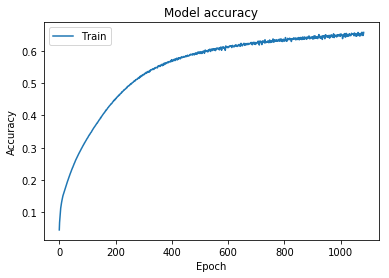

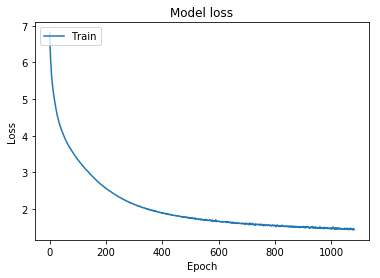

In [74]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(model.history.history['acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('acc.png', bbox_inches='tight')
plt.show()

# Plot training & validation loss values
plt.plot(model.history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.savefig('loss.png', bbox_inches='tight')

plt.show()

It looks like our model isn't going to get much better without additional preprocessing or tweaks to the density or depth of our network. Let's see what it does when we give it text to predict.

In [55]:
# Save the model for later
from pickle import dump,load

model.save('trained_model.h5')
dump(tokenizer, open('trained_model', 'wb'))

In [ ]:
# Uncomment this cell if you want to load the previously trained model

#model=load_model('trained_model.h5')
#tokenizer=load(open('trained_model','rb'))

In [59]:
# Now that we have our model trained, we'd like to start making predictive text.

from pickle import load
from keras.models import load_model
from keras.preprocessing.sequence import pad_sequences

In [69]:
def generate_text(model, tokenizer, seq_len, seed_text, num_gen_words):
    '''
    INPUTS:
    model : model that was trained on text data
    tokenizer : tokenizer that was fit on text data
    seq_len : length of training sequence
    seed_text : raw string text to serve as the seed
    num_gen_words : number of words to be generated by model
    '''
    
    # Final Output
    output_text = []
    
    # Intial Seed Sequence
    input_text = seed_text
    
    # Create num_gen_words
    for i in range(num_gen_words):
        
        # Take the input text string and encode it to a sequence
        encoded_text = tokenizer.texts_to_sequences([input_text])[0]
        
        # Pad sequences to our trained rate (50 words in the video)
        pad_encoded = pad_sequences([encoded_text], maxlen=seq_len, truncating='pre')
        
        # Predict Class Probabilities for each word
        pred_word_ind = model.predict_classes(pad_encoded, verbose=0)[0]
        
        # Grab word
        pred_word = tokenizer.index_word[pred_word_ind] 
        
        # Update the sequence of input text (shifting one over with the new word)
        input_text += ' ' + pred_word
        
        output_text.append(pred_word)
        
    # Make it look like a sentence.
    return ' '.join(output_text)

In [75]:
# Type whatever you want as seed text.
seed_text="I"

generate_text(model,tokenizer,seq_len,seed_text=seed_text,num_gen_words=15)

"also has n't have a corrupt dollar told by billion dollars worth of bin laden"

Well.... okay. Clearly we could use some more help, but there you have it!